# Interpretacion de resultados

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
#!pip install lightgbm
#!pip install optuna

In [124]:
import joblib
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dask.dataframe as dd
from sklearn.metrics import mean_squared_error as mse
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import train_test_split

from s3_utils import read_pickle


In [19]:
import shap

In [20]:
#!pip install s3fs

In [21]:
core = pd.read_csv("s3://data-science-kavak-dev/projects/cerberus/v2/dev/income/data/aprobados.csv")
core.shape

(13943, 239)

In [22]:
core = core.query("ingreso_neto_comprobado < 300000")

In [ ]:
#core = core[core["net_income_verified"]>=core["ingreso_neto_comprobado"]]

In [23]:
from evaluation import predict_multiple_models
names = ["%_validated_model", "declarado_final_con_clip_model","declarado_sin_clip_model","sin_declarado_sin_clip_model","sin_declarado_con_clip_model"]
path_models = "s3://data-science-kavak-dev/projects/cerberus/v2/dev/income/models/"
core = predict_multiple_models(core, names, path_models)
core["validated_final_model"] = core["net_income_verified"]*core["%_validated_model"]
core["validated_final_model"] =  core["validated_final_model"].astype(int)

Creating columns %_validated_model
Creating columns declarado_final_con_clip_model
Creating columns declarado_sin_clip_model
Creating columns sin_declarado_sin_clip_model
Creating columns sin_declarado_con_clip_model


In [24]:
core["%_validated_model"].describe()

count    13817.000000
mean         0.921591
std          0.044651
min          0.372486
25%          0.899581
50%          0.927951
75%          0.950837
max          1.013232
Name: %_validated_model, dtype: float64

In [25]:
select_cap = ['Dependientes','Monto_de_la_mensualidad','BC_Score_',
 'Ingreso_',
 'Ing_Disp']
import re
core["Ingreso_"] = core["Ingreso_"].apply(lambda x: re.sub("[^\d\,]", "", str(x)))
core["Ing_Disp"] = core["Ing_Disp"].apply(lambda x: re.sub("[^\d\,]", "", str(x)))
core["Ingreso_"] = [x.replace(',', '.') for x in core["Ingreso_"]]
core["Ing_Disp"]= [x.replace(',', '.') for x in core["Ing_Disp"]]
core["Ingreso_"] = [x.split(".")[0] for x in core["Ingreso_"]]
core["Ing_Disp"] = [x.split(".")[0] for x in core["Ing_Disp"]]
core["Ing_Disp"] = pd.to_numeric(core["Ing_Disp"])
core["Ingreso_"]  = pd.to_numeric(core["Ingreso_"])
core["Dependientes"] = core["Dependientes"].apply(lambda x: re.sub("[^\w]", "", str(x)))
core["Dependientes"] = core["Dependientes"].replace("nan",0)
core["Dependientes"] = core["Dependientes"].replace("None",0)
core["Dependientes"] = pd.to_numeric(core["Dependientes"])
core["Dependientes"]  = core["Dependientes"].fillna(0)
core["descuentos"] =  core["Ingreso_"] - core["Ing_Disp"]
core["Monto_de_la_mensualidad"] = core["Monto_de_la_mensualidad"].apply(lambda x: re.sub("[^\d\,]", "", str(x)))
core["Monto_de_la_mensualidad"] = [x.replace(',', '.') for x in core["Monto_de_la_mensualidad"]]
core["Monto_de_la_mensualidad"] = pd.to_numeric(core["Monto_de_la_mensualidad"])

In [26]:
core["pagos_a_bureau"] = core["descuentos"] + 2000*core["Dependientes"]

# Model evaluation

In [149]:

models = ["validated_final_model", "declarado_final_con_clip_model","declarado_sin_clip_model","sin_declarado_sin_clip_model","sin_declarado_con_clip_model"]


In [150]:
def MAPE_m(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / y_true)
def RMSLE(y_true, y_pred,*args,**kwargs): 
    return np.mean((np.log(1+y_pred)-np.log(1+y_true))**2)**.5



In [151]:
residuals = []
mape = []
rmsle = []
for model in models:
    core[f"{model}_residuals"] = core.apply(lambda x: (x[model]-x["ingreso_neto_comprobado"]), axis=1)
    core[f"{model}_mape"] = core.apply(lambda x: MAPE_m(x["ingreso_neto_comprobado"], x[model]), axis=1)
    core[f"{model}_rmsle"] = core.apply(lambda x: RMSLE(x["ingreso_neto_comprobado"], x[model]), axis=1)
    
    residuals.append(core[f"{model}_residuals"].mean())
    mape.append(core[f"{model}_mape"].mean())
    rmsle.append(core[f"{model}_rmsle"].mean())


In [152]:
results = pd.DataFrame(
    {'modelos': models,
     'residuales': residuals,
     'mape': mape,
     'rmsle': rmsle
    })

results

,modelos,residuales,mape,rmsle
0,validated_final_model,-2431.334408,0.151917,0.144742
1,declarado_final_con_clip_model,-5712.591361,0.465203,0.442664
2,declarado_sin_clip_model,-2675.817720,0.148706,0.142719
3,sin_declarado_sin_clip_model,-2974.690687,0.496666,0.441906
4,sin_declarado_con_clip_model,-5486.126911,0.462148,0.435631


# Casos especificos

### Ingresos Altos

In [164]:
high_df = core.query("ingreso_neto_comprobado > 200000")

In [165]:
columns = models + ["ingreso_neto_comprobado","net_income_verified", "pagos_a_bureau"]

In [166]:
high_df[columnas].T.round(2)

,17,268,368,564,582,617,698,750,799,880,...,12940,12952,12954,13090,13254,13479,13622,13711,13825,13843
%_validated_model,0.68,0.93,0.83,0.87,0.97,0.87,0.94,0.84,0.94,0.91,...,0.91,0.97,0.96,0.81,0.91,0.89,0.92,0.79,0.93,0.96
declarado_final_con_clip_model,101267.89,54274.67,18154.10,69068.79,67765.00,71294.48,22187.47,65743.91,22650.55,37517.29,...,16951.78,83315.62,91200.88,64376.69,80756.26,73946.92,42020.72,67096.39,66043.10,67498.28
declarado_sin_clip_model,187809.87,56364.66,21498.03,130812.02,58107.17,90843.60,23215.05,101457.29,24008.61,46212.88,...,55046.76,225066.73,213649.31,192365.76,227049.53,225759.63,224894.46,125804.63,185111.37,210062.40
sin_declarado_sin_clip_model,125985.32,56157.33,20214.32,145841.80,86855.66,61956.41,33734.50,79542.86,24619.26,36337.44,...,20877.12,158919.39,167046.26,81099.40,86408.44,128622.15,46916.70,74405.11,65817.28,62191.19
sin_declarado_con_clip_model,95483.38,54381.76,17003.34,62566.49,71677.80,78249.95,31480.55,70275.34,22535.43,36169.31,...,15364.15,80801.16,93098.05,59748.46,89396.71,80771.14,42081.29,53597.93,56614.25,64131.61
ingreso_neto_comprobado,293504.00,214743.00,240000.00,227487.45,265000.00,260138.00,216770.00,233000.00,201121.00,299817.00,...,231009.27,235000.00,210000.00,250000.00,250000.00,247529.31,250000.00,250000.00,269860.00,245892.00
net_income_verified,293504.00,65000.00,24000.00,155000.00,60000.00,100000.00,25000.00,150000.00,25000.00,50000.00,...,60000.00,235000.00,210000.00,250000.00,250000.00,247529.00,250000.00,180000.00,269860.00,245892.00
pagos_a_bureau,75212.00,5713.00,4094.00,4714.00,36498.00,32654.00,0.00,76056.00,1963.00,18039.00,...,48210.00,149054.00,44857.00,29790.00,96670.00,184325.00,32376.00,165700.00,33052.00,23112.00
validated_final_model,200900.00,60553.00,20019.00,135287.00,58095.00,87178.00,23427.00,125519.00,23484.00,45565.00,...,54300.00,227012.00,202087.00,203676.00,227267.00,219173.00,229762.00,142963.00,251693.00,237157.00


# Ingresos bajos

In [167]:
lowe_df = core.query("ingreso_neto_comprobado < 10000")
lowe_df[columnas].T.round(2)

,23,112,120,250,277,306,342,395,401,475,...,13041,13108,13280,13330,13364,13440,13610,13642,13693,13848
%_validated_model,0.94,0.97,0.95,0.93,0.94,0.95,0.88,0.97,0.91,0.92,...,0.92,0.89,0.93,0.97,0.94,0.93,0.97,0.99,0.98,0.97
declarado_final_con_clip_model,17669.30,16351.53,25222.46,24185.81,20858.18,20891.11,16103.86,15027.60,13954.60,19398.06,...,22957.29,19529.67,21638.80,26322.89,19313.16,18322.90,17114.21,20527.05,29257.67,36481.39
declarado_sin_clip_model,9724.64,9078.77,11596.80,10008.54,9938.39,13605.65,17943.02,9878.57,16133.20,11155.15,...,8813.77,9186.58,8876.04,10225.20,9558.68,9839.83,9482.13,9535.81,11433.69,10064.90
sin_declarado_sin_clip_model,17158.91,17032.75,23428.28,23472.90,18635.87,23518.83,15635.58,21109.03,15201.93,16901.96,...,21489.75,22474.28,19481.50,51806.83,21269.66,17430.28,19424.99,17463.05,21074.59,29677.63
sin_declarado_con_clip_model,14964.40,15872.31,21919.20,23565.49,18939.36,24040.86,17156.88,15182.60,10461.44,18586.44,...,23904.23,23217.93,19845.12,30564.41,22013.63,19138.02,18060.67,20508.46,28675.14,33658.30
ingreso_neto_comprobado,9500.00,8500.00,9000.00,9200.00,8341.00,8200.00,8300.00,8000.00,8495.00,8900.00,...,8000.00,8494.01,7810.58,9969.22,9559.00,9969.06,9025.83,9506.00,5217.00,8000.00
net_income_verified,10000.00,8500.00,12000.00,10000.00,9000.00,15000.00,20000.00,10000.00,18000.00,12000.00,...,8000.00,8494.00,7810.00,9969.00,9559.00,9969.00,9026.00,9506.00,5217.00,8000.00
pagos_a_bureau,610.00,0.00,0.00,278.00,5023.00,0.00,838.00,370.00,250.00,95.00,...,1217.00,12536.00,711.00,0.00,250.00,163.00,0.00,0.00,1893.00,916.00
validated_final_model,9440.00,8203.00,11380.00,9329.00,8432.00,14253.00,17644.00,9659.00,16408.00,11063.00,...,7341.00,7556.00,7292.00,9651.00,8962.00,9291.00,8718.00,9428.00,5102.00,7749.00


# Declaran mas

In [168]:
ingreso_declarado = core[(core["net_income_verified"]>core["ingreso_neto_comprobado"])& (core["net_income_verified"]>100000)]
ingreso_declarado[columnas].T.round(2)

,32,78,102,157,158,159,193,361,400,505,...,11801,12015,12386,12473,12633,12856,12939,13252,13452,13750
%_validated_model,0.78,0.82,0.93,0.45,0.45,0.45,0.96,0.82,0.92,0.85,...,0.83,0.89,0.82,0.89,0.91,0.90,0.85,0.90,0.45,0.91
declarado_final_con_clip_model,84171.38,70418.91,43666.61,96013.28,96013.28,96013.28,105160.40,85832.89,69916.88,63656.06,...,25400.21,47753.05,19232.86,41098.23,45357.09,89666.87,69788.51,23193.54,47779.64,37773.88
declarado_sin_clip_model,150253.51,154207.15,134840.77,149768.30,149768.30,149768.30,223426.66,188248.78,140898.90,187576.28,...,122673.72,103610.32,97449.48,107522.63,100738.76,108790.93,120637.56,128248.69,148695.19,89452.70
sin_declarado_sin_clip_model,108667.06,100791.70,35068.24,224846.42,224846.42,224846.42,192804.31,148010.24,95568.80,67547.36,...,25535.56,57281.28,19562.67,35112.57,64766.02,112158.98,69218.45,23354.69,40421.54,44847.87
sin_declarado_con_clip_model,79635.45,75045.59,35831.26,92189.09,92189.09,92189.09,104074.59,89426.21,69513.40,61394.67,...,25153.38,50222.89,17488.05,47569.22,47397.84,87445.67,71067.24,21692.60,41983.59,39710.45
ingreso_neto_comprobado,172000.00,61800.00,60165.00,140000.00,90000.00,90000.00,150000.00,180000.00,71832.00,120000.00,...,50000.00,92902.06,15032.40,40000.00,37663.13,107107.81,100000.00,35000.00,52000.00,88178.04
net_income_verified,180000.00,180000.00,150000.00,350000.00,350000.00,350000.00,270000.00,190000.00,150000.00,200000.00,...,150000.00,120000.00,120000.00,128000.00,126000.00,120000.00,150000.00,150000.00,520000.00,101000.00
pagos_a_bureau,64940.00,22389.00,8651.00,51994.00,25743.00,25743.00,3511.00,41587.00,38281.00,11981.00,...,383.00,8300.00,250.00,11582.00,19191.00,14699.00,36668.00,16000.00,12131.00,14452.00
validated_final_model,139572.00,147155.00,139026.00,155858.00,155858.00,155858.00,259555.00,155140.00,138437.00,170682.00,...,123751.00,106384.00,97832.00,113615.00,114696.00,107674.00,126902.00,134826.00,232303.00,92238.00


# Shaps

In [27]:
predictor_validated = read_pickle(path_models + "%_validated_model" + ".pkl")
boost_validated = predictor_validated.booster_

In [28]:
predictor_declarado = read_pickle(path_models + "declarado_final_con_clip_model" + ".pkl")
boost_declarado_clip = predictor_declarado.booster_

In [29]:
predictor_declarado_sin_clip = read_pickle(path_models + "declarado_sin_clip_model" + ".pkl")
boost_declarado_sin_clip = predictor_declarado_sin_clip.booster_

In [30]:
predictor_sin_declarado_sin_clip_model = read_pickle(path_models + "sin_declarado_sin_clip_model" + ".pkl")
sin_declarado_sin_clip_model = predictor_sin_declarado_sin_clip_model.booster_

predictor_declarado = read_pickle(path_models + "sin_declarado_con_clip_model" + ".pkl")
boost_declarado = predictor_declarado.booster_
columns_sin = boost_declarado.feature_name()

In [31]:
#core.query("pagos_a_bureau > 700000")

# Shap Values modelos

In [33]:
import shap
explainer_validado = shap.TreeExplainer(boost_validated)
explainer_declarado = shap.TreeExplainer(boost_declarado)
columns = boost_declarado.feature_name()

# Shaps Plots

In [50]:
shap_values2 = explainer_validado(ingresos_out[columns][0:4])
shap_values_decla = explainer_declarado(ingresos_out[columns][0:4])

#### Ingreso 350mil | declarado 350mil | %validated sobreestimacion | declarado subestimacion

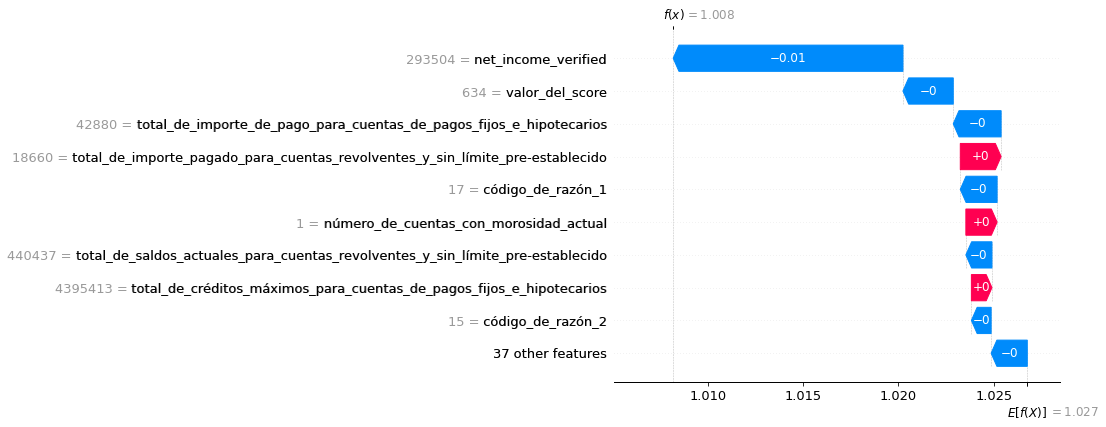

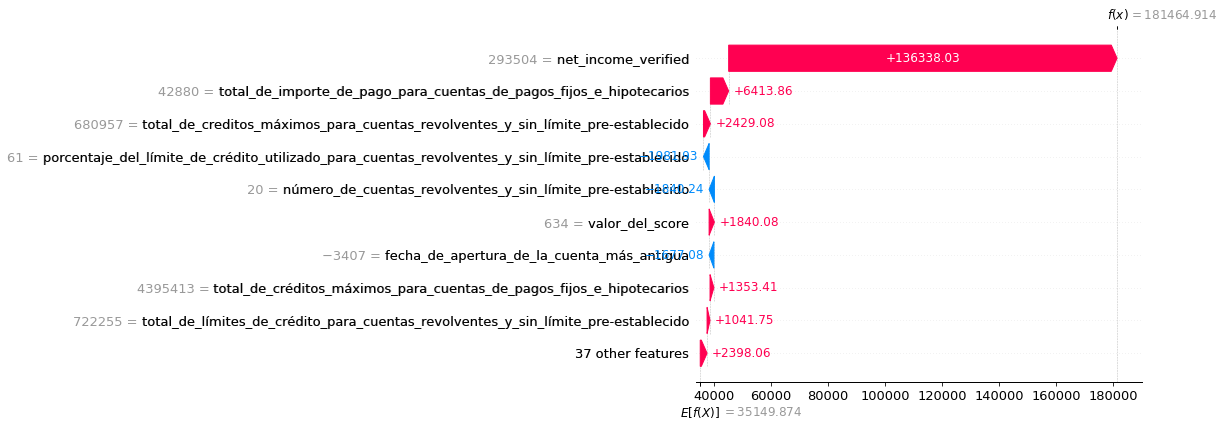

In [52]:
shap.plots.waterfall(shap_values2[0])
shap.plots.waterfall(shap_values_decla[0])

#### Ingreso 800mil | declarado 800mil | %validated sobreestimacion | declarado subestimacion

In [ ]:
shap.plots.waterfall(shap_values2[2])
shap.plots.waterfall(shap_values_decla[2])

# Scatterplots

In [99]:

for model in names:
    core[f"resid_{model}"] = core["ingreso_neto_comprobado"] - core[model]

In [106]:
core.resid_validated_final_model.describe().round(2)

count      13816.00
mean        2431.33
std        20554.56
min     -1656652.00
25%          623.00
50%         1744.00
75%         3635.00
max       254252.00
Name: resid_validated_final_model, dtype: float64

In [104]:
for model in names:
    print(f"resid_{model}")

resid_%_validated_model
resid_declarado_final_con_clip_model
resid_declarado_sin_clip_model
resid_sin_declarado_sin_clip_model
resid_sin_declarado_con_clip_model
resid_validated_final_model


<AxesSubplot:xlabel='ingreso_neto_comprobado', ylabel='resid_sin_declarado_con_clip_model'>

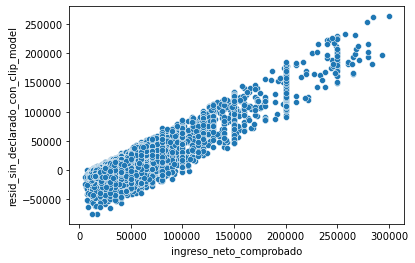

In [94]:
sns.scatterplot(x="ingreso_neto_comprobado",y="resid_sin_declarado_con_clip_model", data=core)

(-300000.0, 300000.0)

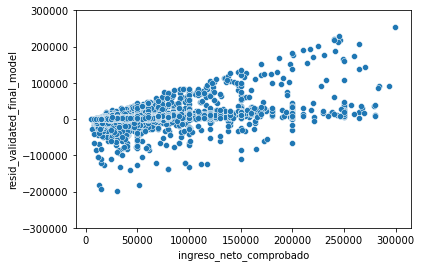

In [113]:
plt.ticklabel_format(style='plain', axis='y')

g = sns.scatterplot(x="ingreso_neto_comprobado",y="resid_validated_final_model", data=core)
g.set_ylim([-300000,300000])

<AxesSubplot:xlabel='ingreso_neto_comprobado', ylabel='resid_sin_declarado_sin_clip_model'>

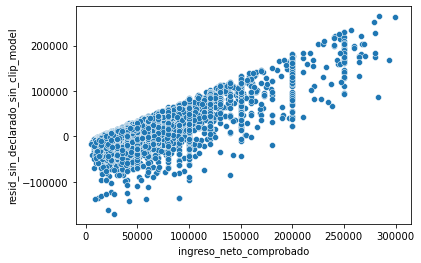

In [114]:
sns.scatterplot(x="ingreso_neto_comprobado",y="resid_sin_declarado_sin_clip_model", data=core)

<AxesSubplot:xlabel='ingreso_neto_comprobado', ylabel='resid_declarado_sin_clip_model'>

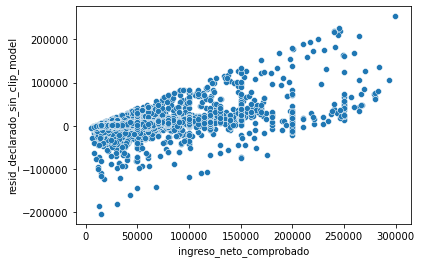

In [115]:
sns.scatterplot(x="ingreso_neto_comprobado",y="resid_declarado_sin_clip_model", data=core)

<AxesSubplot:xlabel='ingreso_neto_comprobado', ylabel='resid_declarado_final_con_clip_model'>

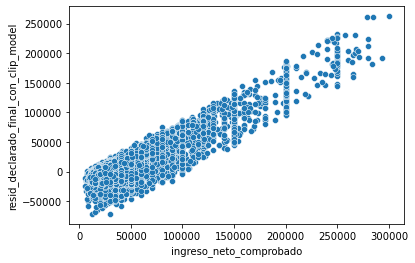

In [116]:
sns.scatterplot(x="ingreso_neto_comprobado",y="resid_declarado_final_con_clip_model", data=core)

<AxesSubplot:xlabel='ingreso_neto_comprobado', ylabel='resid_declarado_sin_clip_model'>

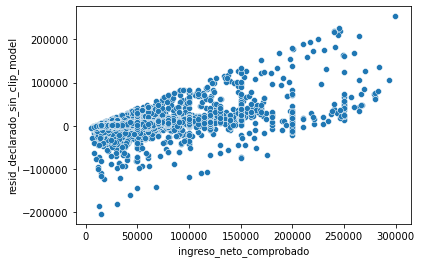

In [117]:
sns.scatterplot(x="ingreso_neto_comprobado",y="resid_declarado_sin_clip_model", data=core)